In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: c:\Users\lauba\Documents\GitHub\chimes_CGD-myLLFork\dissimilarity_clustering


In [3]:
# Get the current working directory
cwd = os.getcwd()

# Define file paths with cwd appended
file_path_2b = os.path.join(cwd, "dft_pds/2b_all_pd")
file_path_3b = os.path.join(cwd, "dft_pds/3b_all_pd")
file_path_4b = os.path.join(cwd, "dft_pds/4b_all_pd")
file_path_labels = os.path.join(cwd, "dft_pds/labels_pd")
file_path_natoms = os.path.join(cwd, "test_notebooks/energies_per_atom.txt")

# Open pickle files with the updated file paths
with open(file_path_2b, 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open(file_path_3b, 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open(file_path_4b, 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

with open(file_path_labels, 'rb') as pickle_file:
    labels = pickle.load(pickle_file)

natom_list = []

# Open the text file for reading
with open(file_path_natoms, 'r') as file:

    # Read the contents of the file
    lines = file.readlines()[1:]

    # Iterate through each line
    for line in lines:

        # Split the line into words
        words = line.split()
        natoms = line.split("|")[1].strip()

        # Extract the last word, assuming it's a number
        last_number = float(words[-1])
        if words[0][-1] == 'z':
            print(words[0])
            continue
        natom_list.append(natoms)

natom_list = np.array(natom_list[:-10])

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((pd_2b, pd_3b, pd_4b), axis=2)
all_array = all_array.reshape(-1, all_array.shape[2])
print(np.shape(all_array))
df_fingerprints = pd.DataFrame(all_array)

# Define the column labels for each set of columns
column_labels_2b = [f'2B_{i}' for i in range(60)]
column_labels_3b = [f'3B_{i}' for i in range(60)]
column_labels_4b = [f'4B_{i}' for i in range(60)]

# Assign the column labels to the DataFrame
column_labels = column_labels_2b + column_labels_3b + column_labels_4b
df_fingerprints.columns = column_labels

# Add a new column "labels" to the DataFrame and assign the new vector to it
df_fingerprints['labels'] = labels

# Calculate the row-wise mean using `mean(axis=1)`
row_avg = df_fingerprints.mean(axis=1)

# Append the calculated row-wise mean as a new column named "Pavg"
df_fingerprints['Pavg'] = row_avg

# Calculate the row-wise standard deviation using `std(axis=1)`
row_std = df_fingerprints.std(axis=1)

# Append the calculated row-wise standard deviation as a new column named "Pstd"
df_fingerprints['Pstd'] = row_std

# Append Natoms to Dataframe
df_fingerprints['Natoms'] = natom_list

# Display the DataFrame with the new column
print(df_fingerprints.head())


training_data_#0000.xyz
training_data_#0050.xyz
training_data_#0055.xyz
training_data_#0060.xyz
training_data_#0075.xyz
training_data_#0080.xyz
training_data_#0110.xyz
(300, 180)
       2B_0      2B_1      2B_2      2B_3      2B_4      2B_5      2B_6  \
0  0.151940  0.079974  0.039987  0.134957  0.000000  0.039987  0.000000   
1  0.151838  0.089548  0.030670  0.107863  0.026939  0.039628  0.000530   
2  0.152059  0.091794  0.027968  0.104630  0.029103  0.039305  0.001128   
3  0.113888  0.093885  0.074372  0.063481  0.048075  0.037675  0.033869   
4  0.118745  0.094125  0.073008  0.061039  0.048168  0.036493  0.032401   

       2B_7      2B_8      2B_9  ...  4B_54  4B_55  4B_56  4B_57  4B_58  \
0  0.059981  0.000000  0.064979  ...    0.0    0.0    0.0    0.0    0.0   
1  0.059527  0.008709  0.053400  ...    0.0    0.0    0.0    0.0    0.0   
2  0.058054  0.005966  0.057973  ...    0.0    0.0    0.0    0.0    0.0   
3  0.031662  0.025958  0.021373  ...    0.0    0.0    0.0    0.0    0.

Row with the smallest pij value:
2B_0      0.097704
2B_1      0.082399
2B_2      0.070194
2B_3      0.061471
2B_4      0.053926
            ...   
4B_59          0.0
labels          11
Pavg      0.077133
Pstd      0.814352
Natoms         200
Name: 275, Length: 184, dtype: object
First 5 rows with the smallest pij values:
Row index: 275, pij value: -0.039372287981302476
Row index: 278, pij value: -0.03937225052206747
Row index: 277, pij value: -0.03937220395222774
Row index: 282, pij value: -0.039372196039599384
Row index: 294, pij value: -0.039372189970796695


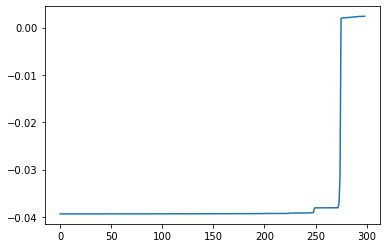

In [4]:
# Proof of concept

# Choose arbitrary starting point
phi1 = df_fingerprints.iloc[0]
phi1_fingerprint = phi1.iloc[:-4]
avg_phi1 = phi1.iloc[-3]
std_phi1 = phi1.iloc[-2]
natoms_phi1 = float(phi1.iloc[-1])

# Compute correlation
diff_phi1 = np.sum(phi1_fingerprint-avg_phi1)
pij_list = []
min_pij = np.inf  # Initialize min_pij to positive infinity
min_row_index = None  # Initialize min_row_index to None
smallest_pij_values = [(np.inf, None)] * 5

# Iterate over each row in df_fingerprints
for index, row in df_fingerprints.iterrows():
    # Skip the first row as it was already selected as phi1
    if index == 0:
        continue
    
    # Select the fingerprint and relevant values for phi2
    phi2_fingerprint = row.iloc[:-4]
    avg_phi2 = row.iloc[-3]
    std_phi2 = row.iloc[-2]
    natoms_phi2 = float(row.iloc[-1])

    # Compute correlation
    diff_phi2 = np.sum(phi2_fingerprint - avg_phi2)
    numerator = diff_phi1 * diff_phi2
    denominator = natoms_phi1 * std_phi1 * std_phi2
    pij = numerator / denominator
    pij_list.append(pij)
        # Update min_pij and min_row_index if current pij is smaller
    if pij < min_pij:
        min_pij = pij
        min_row_index = index
    # Update the list of smallest pij values
    smallest_pij_values.sort()  # Sort the list to ensure smallest values are at the beginning
    if pij < smallest_pij_values[-1][0]:
        smallest_pij_values[-1] = (pij, index)

plt.plot(sorted(pij_list))
# Print the row with the smallest pij value
print("Row with the smallest pij value:")
print(df_fingerprints.iloc[min_row_index])

# Print the first 5 rows with the smallest pij values
print("First 5 rows with the smallest pij values:")
for pij_value, row_index in smallest_pij_values:
    print(f"Row index: {row_index}, pij value: {pij_value}")
    #print(df_fingerprints.iloc[row_index])

# In theory, would add these frames to the TS, but they are all from the same SP -> probably correlated


In [5]:
# Define the size of each chunk
chunk_size = 25

# Initialize an empty list to store the chunks
chunk_list = []

# Iterate over the rows of df_fingerprints in chunks of size chunk_size
for i in range(0, len(df_fingerprints), chunk_size):
    # Select a chunk of rows
    chunk = df_fingerprints.iloc[i:i+chunk_size]
    
    # Assign the chunk to a variable with a dynamic name (e.g., sp1, sp2, ...)
    globals()[f'sp{i//chunk_size + 1}'] = chunk
    
    # Append the chunk to the list
    chunk_list.append(chunk)

# Now, sp1, sp2, ..., will contain the first 25, next 25, ..., rows of df_fingerprints
print(np.shape(chunk_list))


(12, 25, 184)


In [6]:
#print(chunk_list[0].iloc[0])
def compute_pij(phi1, phi2):

    # Compute statistics for phi1
    phi1_fingerprint = phi1.iloc[:-4]
    avg_phi1 = phi1.iloc[-3]
    std_phi1 = phi1.iloc[-2]
    natoms_phi1 = float(phi1.iloc[-1])

    # Compute statistics for phi2
    phi2_fingerprint = phi2.iloc[:-4]
    avg_phi2 = phi2.iloc[-3]
    std_phi2 = phi2.iloc[-2]
    natoms_phi2 = float(phi2.iloc[-1])

    # Standardize Natoms
    natoms = np.sqrt(natoms_phi1*natoms_phi2) # Modification to Pij from BL

    # Compute Pij
    diff_phi1 = np.sum(phi1_fingerprint-avg_phi1)
    diff_phi2 = np.sum(phi2_fingerprint-avg_phi2)
    numerator = diff_phi1*diff_phi2
    denominator = natoms*std_phi1*std_phi2
    pij = numerator/denominator

    return pij

# Initialize values
previous_phi = chunk_list[0].iloc[0] # Choose first frame of simulation
previous_sp = chunk_list[0].iloc[0][-4]
current_sp = previous_sp
removal_chunk_list = copy.copy(chunk_list)
print(f"Adding Frame 0")
training_set = [previous_phi]
training_frames = [current_sp]

# Set minimization initiazation
min_pij = np.inf  # Initialize min_pij to positive infinity
min_row_index = None  # Initialize min_row_index to None

for sp_index, sp in enumerate(removal_chunk_list):
    if sp_index == current_sp or sp_index == previous_sp:
        continue
    for index, row in sp.iterrows():
        current_phi = row
        current_sp = current_phi.iloc[-4]
        pij = compute_pij(previous_phi, current_phi)
        if pij < min_pij:
            min_pij = pij
            min_row_index = index
            min_row = current_phi
            min_sp = current_sp

training_set.append(min_row)
training_frames.append(min_row_index)

# Remove Starting Frame (One Time Thing)
for sp_index, sp in enumerate(removal_chunk_list):
    if sp_index == previous_sp:
        for index, row in sp.iterrows():
            if index == 0:
                sp.drop(index, inplace=True)
    else:
        continue

# Remove chosen frame
for sp_index, sp in enumerate(removal_chunk_list):
    if sp_index == min_sp:
        for index, row in sp.iterrows():
            if index == min_row_index:
                sp.drop(index, inplace=True)
    else:
        continue

for i in removal_chunk_list:
    print(np.shape(i))

# Start 2nd iteration by removing first frame 

Adding Frame 0
(24, 184)
(25, 184)
(25, 184)
(25, 184)
(25, 184)
(25, 184)
(25, 184)
(25, 184)
(25, 184)
(25, 184)
(24, 184)
(25, 184)


c:\Users\lauba\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
training_frames

[0, 10]